<a href="https://colab.research.google.com/github/srini11govind/skills-github-pages/blob/main/milestone_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

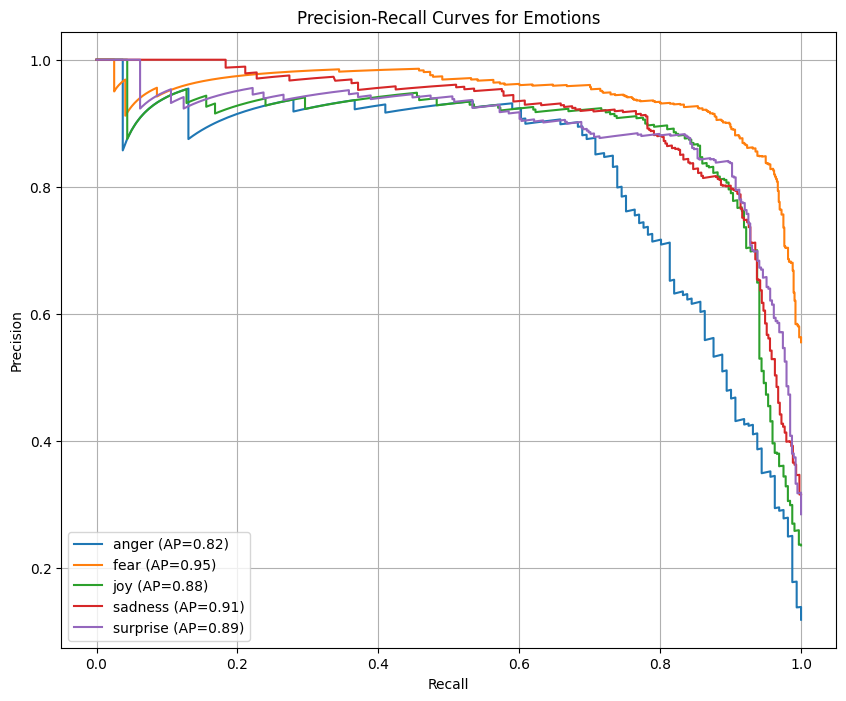

Average Precision (AP) scores per emotion:
anger: 0.821
fear: 0.946
joy: 0.883
sadness: 0.910
surprise: 0.895

Bottleneck emotion label based on AP: anger (AP=0.821)


In [17]:
from transformers import RobertaForSequenceClassification, AutoTokenizer
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split


model_name_or_path = "/content/milestone5"
model = RobertaForSequenceClassification.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()


df = pd.read_csv('/content/train.csv')
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
emotion_labels = ['anger', 'fear', 'joy', 'sadness', 'surprise']


class EmotionDataset(Dataset):
    def __init__(self, df, tokenizer, labels=None):
        self.texts = df['text'].tolist()
        self.labels = None
        if labels is not None:
            self.labels = df[labels].to_numpy()
            self.labels_list = labels
        self.tokenizer = tokenizer
        self.has_labels = labels is not None

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in encoding.items()}
        if self.has_labels:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item


val_dataset = EmotionDataset(val_df, tokenizer, emotion_labels)


def plot_pr_curves_with_ap(model, val_dataset, emotion_labels):
    all_labels, all_probs = [], []
    val_loader = DataLoader(val_dataset, batch_size=32)

    with torch.no_grad():
        for batch in val_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            outputs = model(**inputs)
            logits = outputs.logits.cpu().numpy()
            probs = 1 / (1 + np.exp(-logits))

            all_probs.append(probs)
            all_labels.append(labels.cpu().numpy())

    all_probs = np.vstack(all_probs)
    all_labels = np.vstack(all_labels)

    plt.figure(figsize=(10, 8))

    ap_scores = {}
    for i, label in enumerate(emotion_labels):
        precision, recall, _ = precision_recall_curve(all_labels[:, i], all_probs[:, i])
        ap = average_precision_score(all_labels[:, i], all_probs[:, i])
        ap_scores[label] = ap
        plt.plot(recall, precision, label=f"{label} (AP={ap:.2f})")

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for Emotions')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

    return ap_scores


ap_scores = plot_pr_curves_with_ap(model, val_dataset, emotion_labels)

print("Average Precision (AP) scores per emotion:")
for label, ap in ap_scores.items():
    print(f"{label}: {ap:.3f}")

lowest_ap_label = min(ap_scores, key=ap_scores.get)
print(f"\nBottleneck emotion label based on AP: {lowest_ap_label} (AP={ap_scores[lowest_ap_label]:.3f})")

In [18]:
import numpy as np
from sklearn.metrics import f1_score

def get_probs_and_labels(model, val_dataset):
    model.eval()
    all_labels, all_probs = [], []
    val_loader = DataLoader(val_dataset, batch_size=32)
    with torch.no_grad():
        for batch in val_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            outputs = model(**inputs)
            logits = outputs.logits.cpu().numpy()
            probs = 1 / (1 + np.exp(-logits))
            all_probs.append(probs)
            all_labels.append(labels.cpu().numpy())
    return np.vstack(all_probs), np.vstack(all_labels)


val_probs, val_labels = get_probs_and_labels(model, val_dataset)


thresholds = np.arange(0.05, 0.96, 0.05)
best_thresholds = []
best_f1_per_label = []

for i in range(len(emotion_labels)):
    f1_candidates = []
    for t in thresholds:
        preds = (val_probs[:, i] >= t).astype(int)
        f1 = f1_score(val_labels[:, i], preds, zero_division=0)
        f1_candidates.append(f1)
    best_idx = np.argmax(f1_candidates)
    best_thresholds.append(thresholds[best_idx])
    best_f1_per_label.append(f1_candidates[best_idx])


flat_preds = (val_probs >= 0.5).astype(int)
flat_f1s = [f1_score(val_labels[:, i], flat_preds[:, i], zero_division=0) for i in range(len(emotion_labels))]
macro_f1_flat = np.mean(flat_f1s)


tuned_preds = np.zeros_like(val_probs, dtype=int)
for i, t in enumerate(best_thresholds):
    tuned_preds[:, i] = (val_probs[:, i] >= t).astype(int)
tuned_f1s = [f1_score(val_labels[:, i], tuned_preds[:, i], zero_division=0) for i in range(len(emotion_labels))]
macro_f1_tuned = np.mean(tuned_f1s)

print("Tuned thresholds per emotion:", [round(t, 2) for t in best_thresholds])
print(f"Macro-F1 with flat 0.5 threshold: {macro_f1_flat:.4f}")
print(f"Macro-F1 with tuned thresholds: {macro_f1_tuned:.4f}")

Tuned thresholds per emotion: [np.float64(0.5), np.float64(0.5), np.float64(0.65), np.float64(0.3), np.float64(0.2)]
Macro-F1 with flat 0.5 threshold: 0.8469
Macro-F1 with tuned thresholds: 0.8517


In [23]:
from sklearn.metrics import f1_score
import numpy as np


def get_probs_and_labels(model, val_dataset):
    model.eval()
    all_labels, all_probs = [], []
    val_loader = DataLoader(val_dataset, batch_size=32)
    with torch.no_grad():
        for batch in val_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            outputs = model(**inputs)
            logits = outputs.logits.cpu().numpy()
            probs = 1 / (1 + np.exp(-logits))
            all_probs.append(probs)
            all_labels.append(labels.cpu().numpy())
    return np.vstack(all_probs), np.vstack(all_labels)

val_probs, val_labels = get_probs_and_labels(model, val_dataset)


flat_preds = (val_probs >= 0.5).astype(int)
f1_per_label_pre = [f1_score(val_labels[:, i], flat_preds[:, i], zero_division=0) for i in range(len(emotion_labels))]
macro_f1_pre = np.mean(f1_per_label_pre)

print("Baseline per-label F1 scores (before weighted loss):")
for label, f1 in zip(emotion_labels, f1_per_label_pre):
    print(f"{label}: {f1:.4f}")
print(f"Baseline Macro-F1: {macro_f1_pre:.4f}")

Baseline per-label F1 scores (before weighted loss):
anger: 0.7961
fear: 0.8942
joy: 0.8433
sadness: 0.8601
surprise: 0.8575
Baseline Macro-F1: 0.8503


In [24]:
import torch
from torch import nn
from transformers import Trainer, TrainingArguments

# Compute pos and neg counts and pos_weight vector
pos_counts = train_df[emotion_labels].sum().values
neg_counts = len(train_df) - pos_counts
pos_weights = neg_counts / pos_counts
pos_weights_tensor = torch.tensor(pos_weights, dtype=torch.float).to(device)

print("pos_weight vector:", [round(w.item(), 2) for w in pos_weights_tensor])

#  Define custom loss function with pos_weight for BCEWithLogitsLoss
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weights_tensor)

#  Modify Trainer compute_loss to use this loss_fn
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Prepare training arguments
training_args = TrainingArguments(
    output_dir="./results",
    warmup_steps=500,
    eval_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=50,
    seed=42,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
)

#  datasets
train_dataset = EmotionDataset(train_df, tokenizer, emotion_labels)
val_dataset = EmotionDataset(val_df, tokenizer, emotion_labels)

# Define compute_metrics function to return f1 per label and macro f1
from sklearn.metrics import f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))
    preds = (probs >= 0.5).astype(int)

    f1_scores = [f1_score(labels[:, i], preds[:, i], zero_division=0) for i in range(len(emotion_labels))]
    macro_f1 = np.mean(f1_scores)
    return {"macro_f1": macro_f1, "f1_per_label": f1_scores}

# Instantiate Trainer with WeightedTrainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Fine-tune the model
trainer.train()

# Evaluate and print per-label and macro F1 scores after training
eval_results = trainer.evaluate()
macro_f1_post = eval_results['eval_macro_f1']
f1_per_label_post = eval_results['eval_f1_per_label']

print("\nF1 scores after weighted loss fine-tuning per label:")
for label, f1_val in zip(emotion_labels, f1_per_label_post):
    print(f"{label}: {f1_val:.4f}")
print(f"Macro F1 after weighted loss fine-tuning: {macro_f1_post:.4f}")


improvements = [post - pre for post, pre in zip(f1_per_label_post, f1_per_label_pre)]
max_improve_idx = np.argmax(improvements)
max_worsen_idx = np.argmin(improvements)

print(f"\nMost improved label: {emotion_labels[max_improve_idx]} (Improvement = {improvements[max_improve_idx]:.4f})")
print(f"Most worsened label: {emotion_labels[max_worsen_idx]} (Change = {improvements[max_worsen_idx]:.4f})")

if macro_f1_post > macro_f1_pre:
    print("\nOverall Macro-F1 improved after weighted loss fine-tuning.")
else:
    print("\nOverall Macro-F1 worsened after weighted loss fine-tuning.")

pos_weight vector: [7.44, 0.76, 3.08, 2.14, 2.39]


Epoch,Training Loss,Validation Loss,Macro F1,F1 Per Label
1,0.022100,0.540496,0.839653,"[0.7388888888888889, 0.9073604060913706, 0.8529411764705882, 0.8472222222222222, 0.8518518518518519]"
2,0.020700,0.615184,0.851971,"[0.7781350482315113, 0.9011703511053316, 0.8688783570300158, 0.8482676224611708, 0.8634020618556701]"
3,0.041600,0.681836,0.837357,"[0.7588424437299035, 0.8959795788130185, 0.8404423380726699, 0.8380520951302378, 0.8534704370179949]"


Trainer is attempting to log a value of "[0.7388888888888889, 0.9073604060913706, 0.8529411764705882, 0.8472222222222222, 0.8518518518518519]" of type <class 'list'> for key "eval/f1_per_label" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7781350482315113, 0.9011703511053316, 0.8688783570300158, 0.8482676224611708, 0.8634020618556701]" of type <class 'list'> for key "eval/f1_per_label" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7588424437299035, 0.8959795788130185, 0.8404423380726699, 0.8380520951302378, 0.8534704370179949]" of type <class 'list'> for key "eval/f1_per_label" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.7781350482315113, 0.9011703511053316, 0.8688783570300158, 0.8482676224611708, 0.8634020618556701]" of type <class 'list'> for key "eval/f1_per_label" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.



F1 scores after weighted loss fine-tuning per label:
anger: 0.7781
fear: 0.9012
joy: 0.8689
sadness: 0.8483
surprise: 0.8634
Macro F1 after weighted loss fine-tuning: 0.8520

Most improved label: joy (Improvement = 0.0255)
Most worsened label: anger (Change = -0.0180)

Overall Macro-F1 improved after weighted loss fine-tuning.


In [36]:
import torch
import torch.nn as nn
from transformers import RobertaModel
from transformers import Trainer, TrainingArguments
from sklearn.metrics import f1_score
import numpy as np
from torch.utils.data import Dataset


class RobertaClsHead(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.roberta.config.hidden_size, num_labels)
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_embeds = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_embeds)
        loss = None
        if labels is not None:
            loss = nn.BCEWithLogitsLoss()(logits, labels)
        return (loss, logits) if loss is not None else logits

class RobertaMeanHead(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.roberta.config.hidden_size, num_labels)
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        token_embeds = outputs.last_hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
        sum_embeds = torch.sum(token_embeds * input_mask_expanded, dim=1)
        sum_mask = torch.clamp(input_mask_expanded.sum(dim=1), min=1e-9)
        mean_embeds = sum_embeds / sum_mask
        logits = self.classifier(mean_embeds)
        loss = None
        if labels is not None:
            loss = nn.BCEWithLogitsLoss()(logits, labels)
        return (loss, logits) if loss is not None else logits

class RobertaMaxHead(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.roberta.config.hidden_size, num_labels)
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        token_embeds = outputs.last_hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
        masked_embeds = token_embeds.masked_fill(input_mask_expanded == 0, -1e9)
        max_embeds, _ = torch.max(masked_embeds, dim=1)
        logits = self.classifier(max_embeds)
        loss = None
        if labels is not None:
            loss = nn.BCEWithLogitsLoss()(logits, labels)
        return (loss, logits) if loss is not None else logits


class EmotionDataset(Dataset):
    def __init__(self, df, tokenizer, labels=None, max_length=128):
        self.texts = df['text'].tolist()
        self.labels = None
        if labels is not None:
            self.labels = df[labels].to_numpy(dtype=np.float32)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.has_labels = labels is not None

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(self.texts[idx], max_length=self.max_length,
                                  padding='max_length', truncation=True,
                                  return_tensors='pt')
        item = {k: v.squeeze(0) for k, v in encoding.items()}
        if self.has_labels:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        loss, outputs = model(**inputs, labels=labels)
        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))
    preds = (probs >= 0.5).astype(int)
    f1_per_label = [f1_score(labels[:, i], preds[:, i], zero_division=0) for i in range(labels.shape[1])]
    macro_f1 = np.mean(f1_per_label)
    return {"macro_f1": macro_f1, "f1_per_label": f1_per_label}


from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

train_dataset = EmotionDataset(train_df, tokenizer, emotion_labels)
val_dataset = EmotionDataset(val_df, tokenizer, emotion_labels)

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    eval_strategy="epoch",
    save_strategy="no",
    logging_strategy="epoch",
    learning_rate=2e-5,
    seed=42,

)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


cls_model = RobertaClsHead("roberta-base", len(emotion_labels)).to(device)
mean_model = RobertaMeanHead("roberta-base", len(emotion_labels)).to(device)
max_model = RobertaMaxHead("roberta-base", len(emotion_labels)).to(device)


def train_and_evaluate(model):
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        #remove_unused_columns=False,
    )
    trainer.train()
    eval_results = trainer.evaluate()
    return eval_results["eval_macro_f1"]

cls_macro_f1 = train_and_evaluate(cls_model)
mean_macro_f1 = train_and_evaluate(mean_model)
max_macro_f1 = train_and_evaluate(max_model)

print(f"Macro F1 Scores: [cls: {cls_macro_f1:.4f}, mean: {mean_macro_f1:.4f}, max: {max_macro_f1:.4f}]")

best_score = max(cls_macro_f1, mean_macro_f1, max_macro_f1)
if best_score == cls_macro_f1:
    winner = "[CLS] token head"
elif best_score == mean_macro_f1:
    winner = "Mean Pooling head"
else:
    winner = "Max Pooling head"

print(f"\nWinner: {winner}")

print("""
Using different pooling methods can extract diverse contextual information from the token embeddings.
- [CLS] token usually captures sentence-level summary best learned for classification.
- Mean pooling smooths over all tokens, potentially capturing broader context useful for nuanced emotions.
- Max pooling picks strongest signals, which can highlight salient emotions in some texts.

For this emotion classification dataset, the winner shows what representation better generalizes the multiple labels. Often mean pooling helps emotions by capturing distributed cues beyond a single token.
""")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


ValueError: Found input variables with inconsistent numbers of samples: [1366, 1280]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with CosineAnnealingWarmRestarts
Epoch 1/10, Macro F1: 0.6983, LR: 0.000026
Epoch 2/10, Macro F1: 0.7788, LR: 0.000001
Epoch 3/10, Macro F1: 0.8033, LR: 0.000026
Epoch 4/10, Macro F1: 0.8238, LR: 0.000001
Epoch 5/10, Macro F1: 0.8200, LR: 0.000026
Epoch 6/10, Macro F1: 0.8444, LR: 0.000001
Epoch 7/10, Macro F1: 0.8238, LR: 0.000026
Epoch 8/10, Macro F1: 0.8444, LR: 0.000001
Epoch 9/10, Macro F1: 0.8149, LR: 0.000026
Epoch 10/10, Macro F1: 0.8363, LR: 0.000001


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training with StepLR
Epoch 1/10, Macro F1: 0.6603, LR: 0.000050
Epoch 2/10, Macro F1: 0.7199, LR: 0.000050
Epoch 3/10, Macro F1: 0.7849, LR: 0.000050
Epoch 4/10, Macro F1: 0.8238, LR: 0.000025
Epoch 5/10, Macro F1: 0.8303, LR: 0.000025
Epoch 6/10, Macro F1: 0.8263, LR: 0.000025
Epoch 7/10, Macro F1: 0.8371, LR: 0.000013
Epoch 8/10, Macro F1: 0.8401, LR: 0.000013
Epoch 9/10, Macro F1: 0.8445, LR: 0.000013
Epoch 10/10, Macro F1: 0.8425, LR: 0.000006


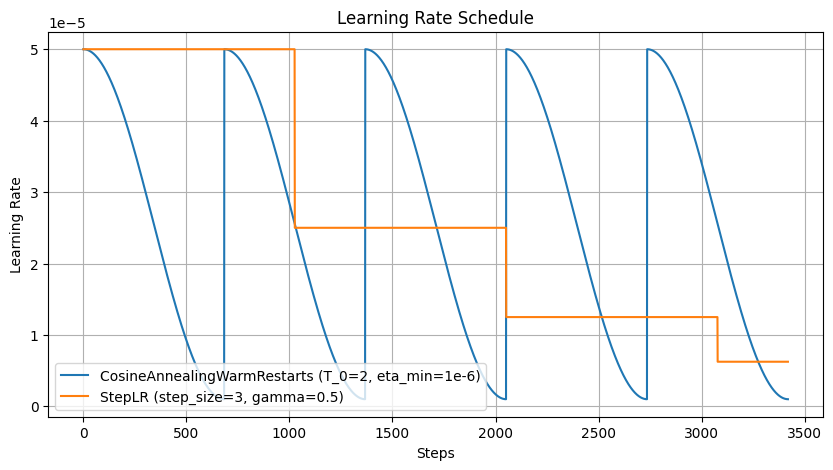

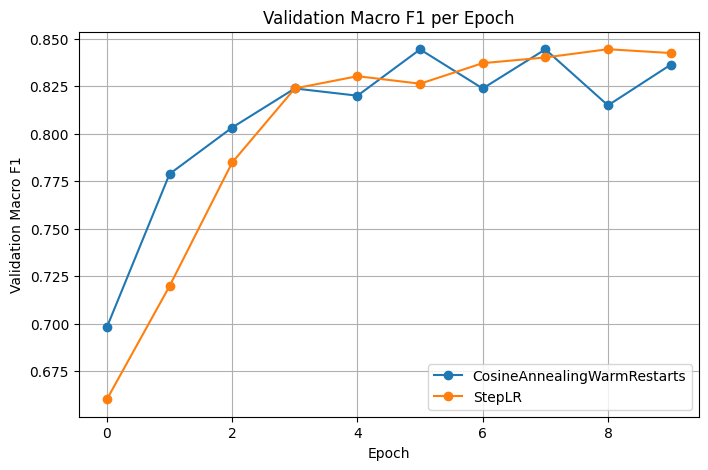

Final Macro F1 CosineAnnealingWarmRestarts: 0.8363
Final Macro F1 StepLR: 0.8425

Scheduler with better validation Macro F1: StepLR
Training longer with the better scheduler might further improve performance by better exploring the loss surface and escaping local minima.


In [32]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, StepLR
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader

def train_with_scheduler(model, train_dataset, val_dataset, optimizer, scheduler, num_epochs=10, batch_size=16):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    lr_history = []
    macro_f1_history = []

    for epoch in range(num_epochs):
        model.train()
        for step, batch in enumerate(train_loader):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(**inputs)
            logits = outputs.logits
            loss = torch.nn.BCEWithLogitsLoss()(logits, labels)
            loss.backward()
            optimizer.step()
            scheduler.step(epoch + step / len(train_loader))

            lr_history.append(optimizer.param_groups[0]['lr'])

        # Validation
        model.eval()
        all_labels = []
        all_probs = []
        with torch.no_grad():
            for batch in val_loader:
                inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
                labels = batch['labels'].to(device)
                outputs = model(**inputs)
                logits = outputs.logits.cpu().numpy()
                probs = 1 / (1 + np.exp(-logits))  # sigmoid
                all_probs.append(probs)
                all_labels.append(labels.cpu().numpy())
        all_probs = np.vstack(all_probs)
        all_labels = np.vstack(all_labels)

        preds = (all_probs >= 0.5).astype(int)
        f1_scores = [f1_score(all_labels[:, i], preds[:, i], zero_division=0) for i in range(all_labels.shape[1])]
        macro_f1 = np.mean(f1_scores)
        macro_f1_history.append(macro_f1)
        print(f"Epoch {epoch + 1}/{num_epochs}, Macro F1: {macro_f1:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

    return lr_history, macro_f1_history


model_name = "roberta-base"
num_labels = len(emotion_labels)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
train_dataset = EmotionDataset(train_df, tokenizer, emotion_labels)
val_dataset = EmotionDataset(val_df, tokenizer, emotion_labels)


optimizer_cosine = AdamW(model.parameters(), lr=5e-5)
scheduler_cosine = CosineAnnealingWarmRestarts(optimizer_cosine, T_0=2, T_mult=1, eta_min=1e-6)


print("Training with CosineAnnealingWarmRestarts")
lr_cosine, f1_cosine = train_with_scheduler(model, train_dataset, val_dataset, optimizer_cosine, scheduler_cosine)


model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
optimizer_step = AdamW(model.parameters(), lr=5e-5)
scheduler_step = StepLR(optimizer_step, step_size=3, gamma=0.5)


print("\nTraining with StepLR")
lr_step, f1_step = train_with_scheduler(model, train_dataset, val_dataset, optimizer_step, scheduler_step)

plt.figure(figsize=(10,5))
plt.plot(lr_cosine, label="CosineAnnealingWarmRestarts (T_0=2, eta_min=1e-6)")
plt.plot(lr_step, label="StepLR (step_size=3, gamma=0.5)")
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(8,5))
plt.plot(f1_cosine, marker='o', label="CosineAnnealingWarmRestarts")
plt.plot(f1_step, marker='o', label="StepLR")
plt.xlabel("Epoch")
plt.ylabel("Validation Macro F1")
plt.title("Validation Macro F1 per Epoch")
plt.legend()
plt.grid(True)
plt.show()

print(f"Final Macro F1 CosineAnnealingWarmRestarts: {f1_cosine[-1]:.4f}")
print(f"Final Macro F1 StepLR: {f1_step[-1]:.4f}")

if f1_cosine[-1] > f1_step[-1]:
    better = "CosineAnnealingWarmRestarts"
else:
    better = "StepLR"
print(f"\nScheduler with better validation Macro F1: {better}")
print("Training longer with the better scheduler might further improve performance by better exploring the loss surface and escaping local minima.")

In [ ]:
import matplotlib.pyplot as plt
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, StepLR
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
import numpy as np

def train_with_scheduler(model, train_dataset, val_dataset, optimizer, scheduler, num_epochs=10, batch_size=16):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    lr_history = []
    macro_f1_history = []

    for epoch in range(num_epochs):
        model.train()
        for step, batch in enumerate(train_loader):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(**inputs)
            logits = outputs.logits
            loss = torch.nn.BCEWithLogitsLoss()(logits, labels)
            loss.backward()
            optimizer.step()

            if isinstance(scheduler, CosineAnnealingWarmRestarts):
                scheduler.step(epoch + step / len(train_loader))
            elif isinstance(scheduler, StepLR):
                if step == 0:
                    scheduler.step()

            lr_history.append(optimizer.param_groups[0]['lr'])


        model.eval()
        all_labels = []
        all_probs = []
        with torch.no_grad():
            for batch in val_loader:
                inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
                labels = batch['labels'].to(device)
                outputs = model(**inputs)
                logits = outputs.logits.cpu().numpy()
                probs = 1 / (1 + np.exp(-logits))
                all_probs.append(probs)
                all_labels.append(labels.cpu().numpy())

        all_probs = np.vstack(all_probs)
        all_labels = np.vstack(all_labels)

        preds = (all_probs >= 0.5).astype(int)
        f1s = [f1_score(all_labels[:, i], preds[:, i], zero_division=0) for i in range(all_labels.shape[1])]
        macro_f1 = np.mean(f1s)
        macro_f1_history.append(macro_f1)
        print(f"Epoch {epoch+1}/{num_epochs}, Macro F1: {macro_f1:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

    return lr_history, macro_f1_history


model_name = "roberta-base"
num_labels = len(emotion_labels)
model_cosine = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model_step = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

optimizer_cosine = AdamW(model_cosine.parameters(), lr=5e-5)
scheduler_cosine = CosineAnnealingWarmRestarts(optimizer_cosine, T_0=2, T_mult=1, eta_min=1e-6)

optimizer_step = AdamW(model_step.parameters(), lr=5e-5)
scheduler_step = StepLR(optimizer_step, step_size=3, gamma=0.5)

print("Training with CosineAnnealingWarmRestarts")
lr_cosine, f1_cosine = train_with_scheduler(model_cosine, train_dataset, val_dataset, optimizer_cosine, scheduler_cosine)

print("\nTraining with StepLR")
lr_step, f1_step = train_with_scheduler(model_step, train_dataset, val_dataset, optimizer_step, scheduler_step)


plt.figure(figsize=(10,5))
plt.plot(lr_cosine, label="CosineAnnealingWarmRestarts (T_0=2, eta_min=1e-6)")
plt.plot(lr_step, label="StepLR (step_size=3, gamma=0.5)")
plt.xlabel("Optimizer Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule Comparison")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(8,5))
plt.plot(f1_cosine, marker='o', label="CosineAnnealingWarmRestarts")
plt.plot(f1_step, marker='o', label="StepLR")
plt.xlabel("Epoch")
plt.ylabel("Validation Macro F1 Score")
plt.title("Validation Macro F1 per Epoch")
plt.legend()
plt.grid(True)
plt.show()

print(f"\nFinal Validation Macro F1 with CosineAnnealingWarmRestarts: {f1_cosine[-1]:.4f}")
print(f"Final Validation Macro F1 with StepLR: {f1_step[-1]:.4f}")

better_scheduler = "CosineAnnealingWarmRestarts" if f1_cosine[-1] > f1_step[-1] else "StepLR"
print(f"\nBetter scheduler based on final validation Macro F1: {better_scheduler}")
print("Training longer with the better scheduler may help escape local minima more effectively and improve performance.")